# Modeling BLS signal from a single magnetic layer by the reciprocity theorem

This example shows how SpinWaveToolkit (SWT) can be used to calculate the BLS signal by the reciprocity theorem. The input electric fields can be calculated by SWT or FDTD.

First, all the modules need to be imported, and parameters defined.

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import SpinWaveToolkit as SWT
from scipy.ndimage import map_coordinates

In [48]:
# Define parameters
Bext = 30e-3         # External field [T]
theta = np.pi / 2    # Out-of-plane angle (fixed)
d_layer = 30e-9     # Magnetic layer thickness [m]
material = SWT.NiFe  # Material (from toolkit)
Nf_common = 101     # Number of frequency points for Bloch function

NA=0.75           # Numerical Aperture (NA) for the lens

# Define the Kx,Ky grid limits and resolution.
k_min = 1e-6         # minimum k (avoid zero if necessary)
k_max = 20e6        # maximum k (as in original kxi range)
dk = 0.2e6
Nk = round((k_max-k_min)/dk)             # resolution in Kx and Ky

Now, the electric fields need to be calculated. Two will be necessary, with their polarizations perpendicular to one another. You can either generate the fields by SWT, or calculate then numerically (by FDTD).

## (field input) 1st method, SWT:

To generate the field, we will use the ObjectiveLens class. To rotate the polarization, you can use the rotate_field() function.

In [49]:
def rotate_field(Ei_fields, x, y, angle_deg):
    """
    Rotate both polarization and spatial distribution of 2D electric field.

    Parameters
    ----------
    Ei_fields : list of 3 complex 2D arrays [Ex, Ey, Ez]
    x, y : 1D arrays of grid coordinates
    angle_deg : rotation angle, counter-clockwise

    Returns
    -------
    Ex_rot, Ey_rot, Ez_rot : rotated fields
    """
    Ex, Ey, Ez = Ei_fields
    theta = np.deg2rad(angle_deg)
    cos_t, sin_t = np.cos(theta), np.sin(theta)

    # Rotate polarization
    Ejx = cos_t*Ex - sin_t*Ey
    Ejy = sin_t*Ex + cos_t*Ey
    Ejz = Ez.copy()

    # Rotate coordinates
    X, Y = np.meshgrid(x, y, indexing='ij')
    Xr =  cos_t*X + sin_t*Y
    Yr =  -sin_t*X + cos_t*Y

    # Interpolate fields onto rotated grid
    coords = [(Xr - x[0])/(x[1]-x[0]), (Yr - y[0])/(y[1]-y[0])]  # normalized indices
    Ex_rot = map_coordinates(Ejx, coords, order=1, mode='nearest')
    Ey_rot = map_coordinates(Ejy, coords, order=1, mode='nearest')
    Ez_rot = map_coordinates(Ejz, coords, order=1, mode='nearest')

    return Ex_rot, Ey_rot, Ez_rot

In [50]:
print("Preparing focal field...")
objective = SWT.bls.ObjectiveLens(NA=NA, wavelength=532e-9, f0=10, f=1e-3)
xi, yi, Ex, Ey, Ez = objective.getFocalField(z=0, rho_max=10e-6, N=400)
Ei_fields = [Ex, Ey, Ez] 
Ej_fields = rotate_field(Ei_fields, xi, yi, 90) # Field with rotated polarization

Preparing focal field...


## BLS signal calculation

Now, we call GetBlochFunction to calculate the dynamic magnetic moments.

In [51]:
print("Preparing dynamic susceptibility tensor...")

# Setup k-space grid 
kx_grid = np.linspace(-k_max, k_max, Nk)
ky_grid = np.linspace(-k_max, k_max, Nk)
KX, KY = np.meshgrid(kx_grid, ky_grid, indexing="ij")

# k-magnitude and propagation angle
phi0 = np.pi / 2
kxi = np.sqrt(KX**2 + KY**2)
phi = SWT.wrapAngle(np.arctan2(KY, KX) + phi0)
phi[kxi <= 1e-12] = 0.0  # avoid undefined angle at k=0

# Flatten for vectorized evaluation
kxi_fl = kxi.flatten()
phi_fl = phi.flatten()

# Allocate Bloch function storage
Bloch2D = np.zeros((Nf_common, Nk, Nk), dtype=complex)
w_common = np.linspace(2 * np.pi * 1e9, 2 * np.pi * 35e9, Nf_common)  # common frequency axis

# ...
# Create a SingleLayer model for the current kxi and phi.
# Note: We pass kxi and phi as flattened arrays of same shape.
model = SWT.SingleLayer(Bext=Bext, kxi=kxi_fl, theta=theta, 
                        phi=phi_fl, d=d_layer, material=material)
# Compute the Bloch functions for n=0,1,2.
# The returned w has shape (Nf_common,) and bf has shape (Nf_common, len(kxi))
w0, bf0 = model.GetBlochFunction(n=0, Nf=Nf_common)
w1, bf1 = model.GetBlochFunction(n=1, Nf=Nf_common)
# reshape Bloch functions to match the Kx,Ky grid shape
bf0 = bf0.reshape((Nf_common, Nk, Nk))
bf1 = bf1.reshape((Nf_common, Nk, Nk))
# Loop over all grid points in the Kx,Ky plane.
for i in range(Nk):
    for j in range(Nk):
        # Interpolate the Bloch functions to the common frequency axis.
        bf0_interp = np.interp(w_common, w0, bf0[:, i, j], left=0, right=0)
        bf1_interp = np.interp(w_common, w1, bf1[:, i, j], left=0, right=0)

        # Sum Bloch functions for n=0,1,2
        Bloch2D[:, i, j] = bf0_interp + bf1_interp

Bloch = [Bloch2D, np.zeros((Nf_common, Nk, Nk), dtype=complex), Bloch2D*1j]
# ...

Preparing dynamic susceptibility tensor...


Finally, we have everything ready to calculate the BLS signal using the reciprocity theorem.

In [52]:
print("Calculating BLS signal...")
sigmaSW, qmEiEj = SWT.bls.getBLSsignal_RT(xi, yi, Ei_fields, Ej_fields, Bloch, kx_grid, ky_grid) # gives us the BLS signal for selected frequencies together with the transfer matrix

Calculating BLS signal...


Plot the BLS signal.

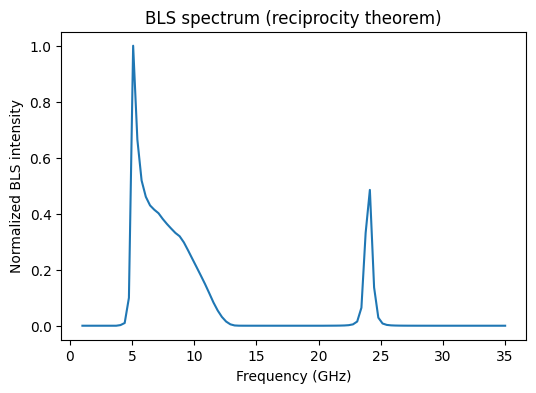

In [53]:
plt.figure(figsize=(6,4))
plt.plot(w_common/2/np.pi/1e9, sigmaSW / np.max(sigmaSW))
plt.xlabel("Frequency (GHz)")
plt.ylabel("Normalized BLS intensity")
plt.title("BLS spectrum (reciprocity theorem)")
plt.show()

(Optional) Plot the transfer function and dynamic magnetic susceptibility tensor

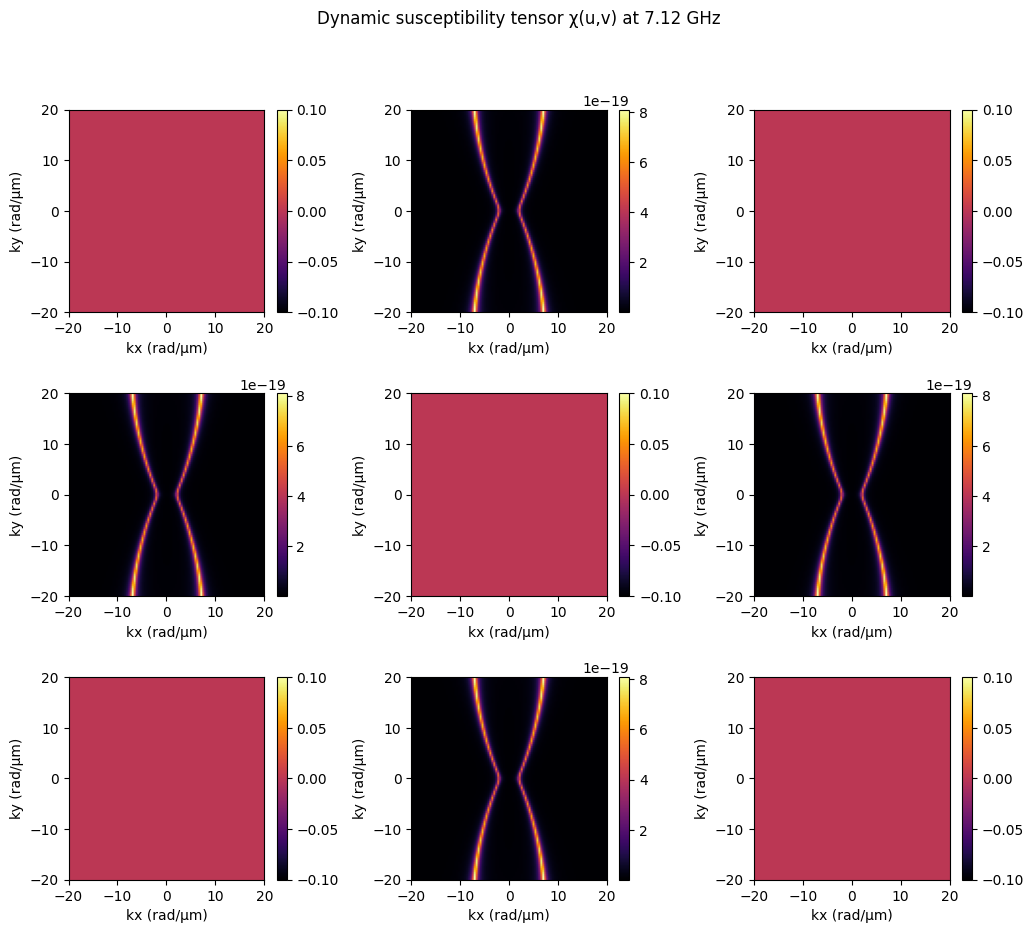

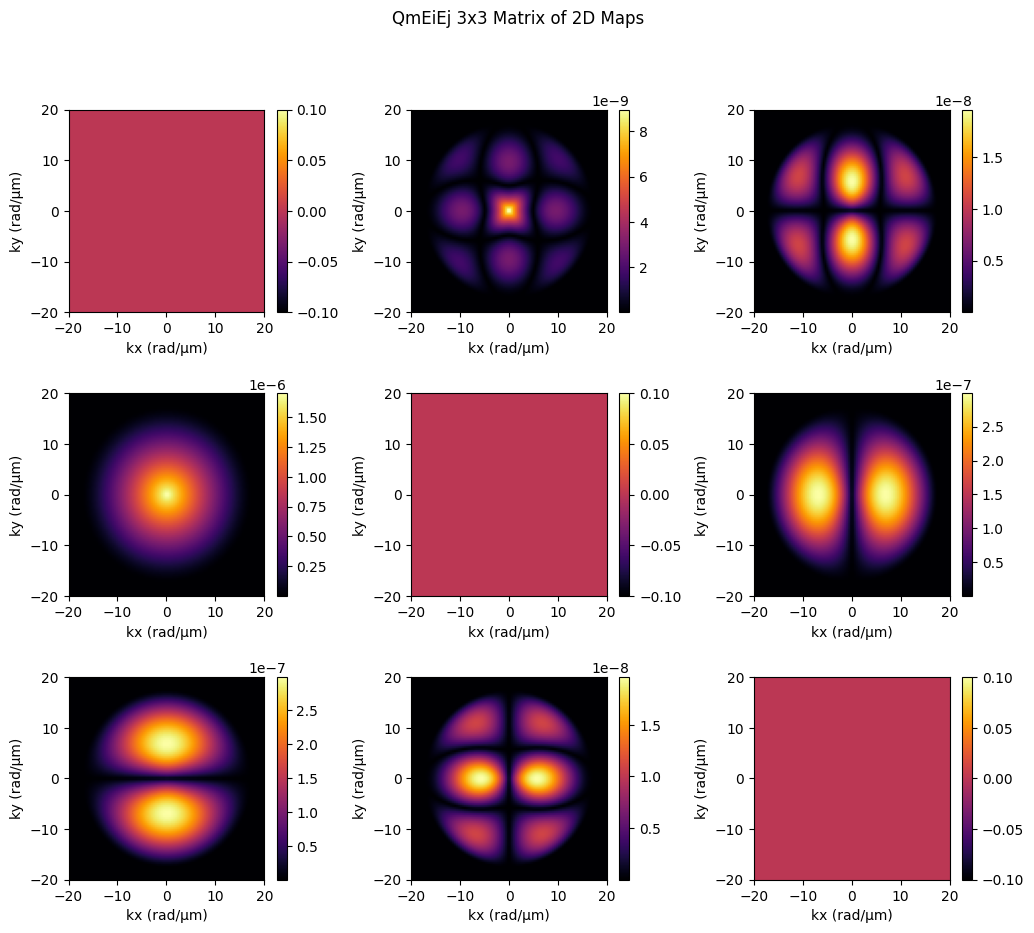

In [54]:
# --- Bloch components (no transpose) ---
mx = Bloch[0]  # (Nf, Nkx, Nky)
my = Bloch[1]
mz = Bloch[2]

_, Nf, Nkx, Nky = np.shape(Bloch)

# --- Susceptibility tensor with Nf as the first dimension ---
chi = np.zeros((3, 3, Nf, Nkx, Nky), dtype=complex)

chi[0, 1] = 1j * mz
chi[0, 2] = -1j * my
chi[1, 0] = -1j * mz
chi[1, 2] = 1j * mx
chi[2, 0] = 1j * my
chi[2, 1] = -1j * mx

# Choose frequency to visualize 
f_desired = 7 # GHz, change this to any frequency you want

# Find the closest index in w_common
f_idx = np.argmin(np.abs(w_common/(2*np.pi*1e9) - f_desired))
f_plot = w_common[f_idx] / (2*np.pi*1e9)

fig, axes = plt.subplots(3, 3, figsize=(12, 10))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for u in range(3):
    for v in range(3):
        ax = axes[u, v]
        im = ax.imshow(
            np.abs(chi[u, v, f_idx, :, :]).T,
            extent=(kx_grid[0]*1e-6, kx_grid[-1]*1e-6,
                    ky_grid[0]*1e-6, ky_grid[-1]*1e-6),
            origin='lower', aspect='auto', cmap='inferno'
        )
        fig.colorbar(im, ax=ax)
        ax.set_xlabel("kx (rad/µm)")
        ax.set_ylabel("ky (rad/µm)")

plt.suptitle(f"Dynamic susceptibility tensor χ(u,v) at {f_plot:.2f} GHz")
plt.show()

# Plot qmEiEj matrix
fig, axes = plt.subplots(3, 3, figsize=(12, 10))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for u in range(3):
    for v in range(3):
        ax = axes[u, v]
        im = ax.imshow(
            np.abs(qmEiEj[u, v]).T,
            extent=(kx_grid[0]*1e-6, kx_grid[-1]*1e-6,
                    ky_grid[0]*1e-6, ky_grid[-1]*1e-6),
            origin='lower', aspect='auto', cmap='inferno'
        )
        fig.colorbar(im, ax=ax)
        ax.set_xlabel("kx (rad/µm)")
        ax.set_ylabel("ky (rad/µm)")

plt.suptitle("QmEiEj 3x3 Matrix of 2D Maps")
plt.show()

## (field input) 2nd method, FDTD

Electric fields can be also calculated by FDTD. Here you can find an example on how to load them.

In [ ]:
def fdtd_loader(filename: str, m: int = 0):
    """
    Load FDTD data from a .mat (v7.3/HDF5) file.

    Parameters
    ----------
    filename : str
        Path to the .mat file (without .mat extension if desired).
    m : int, optional
        Index of the dataset to load (default = 0).

    Returns
    -------
    dict
        Dictionary with fields:
        - xi, yi, zi : spatial grids
        - Ei : electric field, shape (len(xi), len(yi), 3, Nf)
    """
    if not filename.endswith(".mat"):
        filename = filename + ".mat"

    with h5py.File(filename, "r") as f:
        # navigate to Data[m]/ENiFe

        xi   = np.squeeze(np.array(f['#refs#']['#a#']["ENiFe"]["x"]))
        yi   = np.squeeze(np.array(f['#refs#']['#a#']["ENiFe"]["y"]))
        zi   = np.squeeze(np.array(f['#refs#']['#a#']["ENiFe"]["z"]))

        # E is stored as a 4D dataset, reshape like in MATLAB
        raw_E = np.transpose(np.array((f['#refs#']['#a#']["ENiFe"]["E"])))
        # Reshape to [len(xi), len(yi), 3, Nf]
        raw_E = raw_E.reshape((len(xi), len(yi), 3), order="F")
        
        E_real = raw_E['real'][()]
        E_imag = raw_E['imag'][()]
        
        E = E_real + 1j * E_imag

    return xi, yi, zi, [E[:,:,0], E[:,:,1], E[:,:,2]]

In [ ]:
print("Loading FDTD fields...")
xi, yi, zi, Ei_fields = fdtd_loader('MieStripes_RefX')  # incident fields, x-polarized
xj, yj, zj, Ej_fields = fdtd_loader('MieStripes_RefY')  # incident fields, y-polarized